__Dealing With Failure__

We finished the last tutorial on a sour note. Our non-linear search failed miserably, and we were unable to infer a lens model which fitted our realistic data-set well. In this tutorial, we're going to right our past wrongs and infer the correct model - not just once, but three times!

In [ ]:
%matplotlib inline

from autofit import conf
from autofit.optimize import non_linear as nl
from autofit.mapper import prior
from autolens.pipeline import phase as ph
from autolens.model.galaxy import galaxy_model as gm
from autolens.data import ccd
from autolens.data.plotters import ccd_plotters
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.lens.plotters import lens_fit_plotters

In [2]:
# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/howtolens/chapter_2_lens_modeling'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_2_lens_modeling'
conf.instance = conf.Config(config_path=path+'/configs/4_dealing_with_failure', output_path=path+"/output")

Even with my custom config files - the non-linear searches will take a bit of time to run in this tutorial. Whilst you are waiting, I would skip ahead to the cells ahead of the phase-run cells, and sit back and think about the comments, there's a lot to take in in this tutorial so don't feel that you're in a rush!

Alternatively, set these running and come back in 10 minutes or so - MultiNest resumes from the existing results on your hard-disk, so you can rerun things to get the results instantly!

Another simulate image function, albeit it generates a new image

In [3]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing
    
    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)
    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                             effective_radius=0.5, sersic_index=3.5),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=0.8))

    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.5, phi=90.0, intensity=0.03,
                                                       effective_radius=0.3, sersic_index=3.0))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    ccd_simulated = ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                                   exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return ccd_simulated

Simulate the image and plot it.

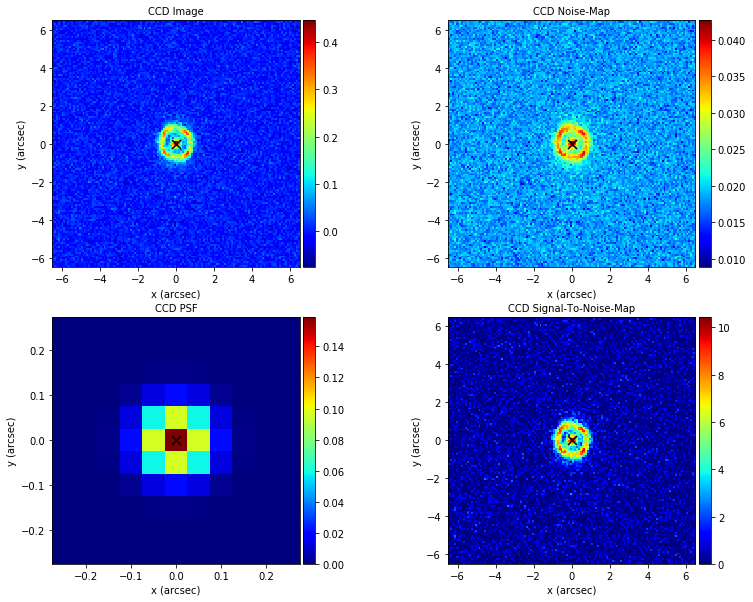

In [4]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

__Approach 1 -  Prior Tuning__

The first approach we're going to take is where we give our non-linear search a helping hand. Lets think about our priors - what they're doing is telling the non-linear search where to look in parameter space. If we tell it to look in the right place (that is, *tune* our priors), it'll probaly find the best-fit lens model.

We've already seen that we can fully customize priors in PyAutoLens, so lets do it. I've set up a custom phase below, and specified a new set of priors that'll give the non-linear search a much better chance at inferring the 'correct model. I've also let you know what we're changing the priors from (as initially specified by the 'config/priors/default' config files.)

In [5]:
class CustomPriorPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # We've called our lens galaxy 'lens' this time, for shorter more readable code.

        # By default, the prior on the (y,x) coordinates of a light / mass profile is a GaussianPrior with mean
        # 0.0" and sigma "1.0. However, visual inspection of our strong lens image tells us that its clearly around
        # x = 0.0" and y = 0.0", so lets reduce where non-linear search looks for these parameters.

        self.lens_galaxies.lens.light.centre_0 = prior.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.light.centre_1 = prior.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.mass.centre_0 = prior.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
        self.lens_galaxies.lens.mass.centre_1 = prior.UniformPrior(lower_limit=-0.05, upper_limit=0.05)

        # By default, the axis-ratio (ellipticity) of our lens galaxy's light profile is a UniformPrior between 0.2 and
        # 1.0. However, by looking at the image it looks fairly circular, so lets use a GaussianPrior nearer 1.0.
        self.lens_galaxies.lens.light.axis_ratio = prior.GaussianPrior(mean=0.8, sigma=0.15)

        # We'll also assume that the light profile's axis_ratio informs us of the mass-profile's axis_ratio, but
        # because this may not strictly be true (e.g. because of dark matter) we'll use a wider prior.
        self.lens_galaxies.lens.mass.axis_ratio = prior.GaussianPrior(mean=0.8, sigma=0.25)

        # By default, the orientation of the galaxy's light profile, phi, uses a UniformPrior between 0.0 and
        # 180.0 degrees. However, if you look really close at the image (and maybe adjust the color-map of the plot),
        # you'll be able to notice that it is elliptical and that it is oriented around 45.0 degrees counter-clockwise
        # from the x-axis. Lets update our prior
        self.lens_galaxies.lens.light.phi = prior.GaussianPrior(mean=45.0, sigma=15.0)

        # Again, lets kind of assume that the light's orientation roughly traces that of mass.
        self.lens_galaxies.lens.mass.phi = prior.GaussianPrior(mean=45.0, sigma=30.0)

        # The effective radius of a light profile is its 'half-light' radius, the radius at which 50% of its
        # total luminosity is internal to a circle defined within that radius. PyAutoLens assumes a
        # UniformPrior on this quantity between 0.0" and 4.0", but inspection of the image (again, using a colormap
        # scaling) shows the lens's light doesn't extend anywhere near 4.0", so lets reduce it.
        self.lens_galaxies.lens.light.effective_radius = prior.GaussianPrior(mean=0.5, sigma=0.8)

        # Typically, we have some knowledge of what morphology our lens galaxy is. Infact, most strong lenses are
        # massive elliptical galaxies, and anyone who studies galaxy morphology will tell you these galaxies have a
        # Sersic index near 4. So lets change our Sersic index from a UniformPrior between 0.8 and 8.0 to reflect this.
        self.lens_galaxies.lens.light.sersic_index = prior.GaussianPrior(mean=4.0, sigma=1.0)

        # Finally, the 'ring' that the lensed source forms clearly has a radius of about 0.8". This is its Einstein
        # radius, so lets change the prior from a UniformPrior between 0.0" and 4.0".
        self.lens_galaxies.lens.mass.einstein_radius = prior.GaussianPrior(mean=0.8, sigma=0.2)

        # In this exercise, I'm not going to change any priors on the source galaxy. Whilst lens modeling experts can
        # look at a strong lens and often tell you roughly where the source-galaxy is located (in the source-plane),
        # it is something of art form. Furthermore, the source's morphology can be pretty complex and it can become
        # very diffcult to come up with a good source prior when this is the case!

We can now create this custom phase and run it. Our non-linear search will start in a much higher likelihood region of parameter space.

In [6]:
custom_prior_phase = CustomPriorPhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                             mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                      phase_name='4_tuned_priors')
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failure'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
custom_prior_result = custom_prior_phase.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failurefolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/4_tuned_priors/optimizer/multinest.txt
Removed no burn in


MultiNest has finished run - you may now continue the notebook.


Bam! We get a good model. The right model. A glorious model! We gave our non-linear search a helping hand, and it repaid us in spades!

Check out the PDF in the '/howstolens/chapter_2_lens_modeling/output/4_custom_priors/image' folder - what degeneracies do you notice between parameters?

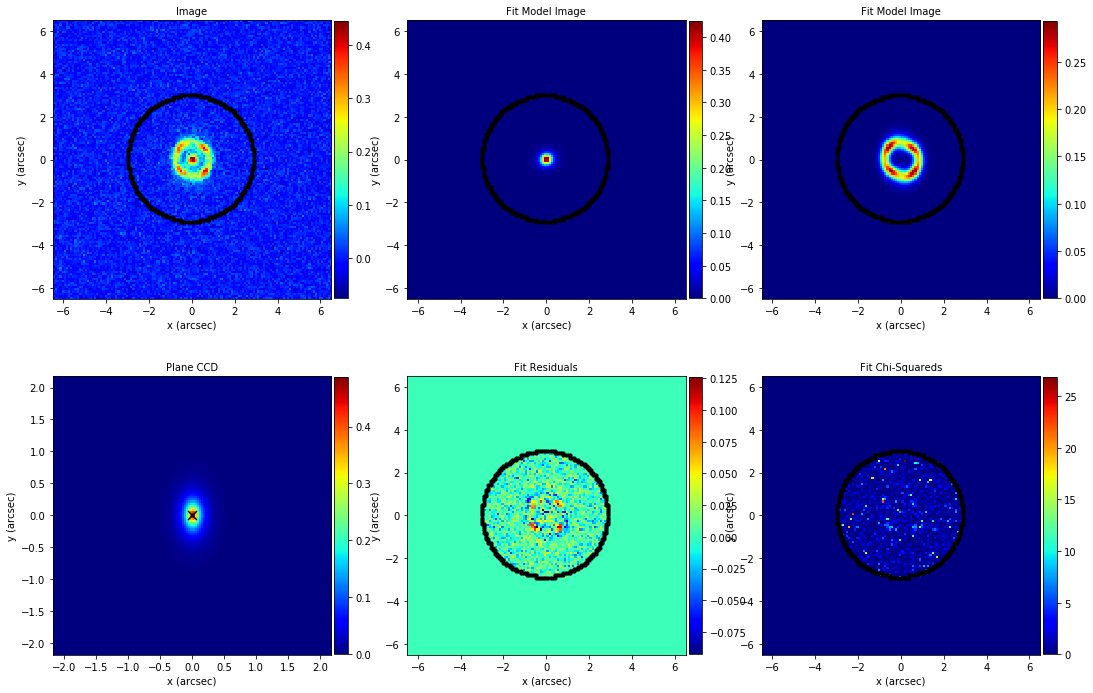

In [7]:
lens_fit_plotters.plot_fit_subplot(fit=custom_prior_result.most_likely_fit)

Okay, so we've learnt that by tuning our priors to the lens we're fitting, we can increase our chance of inferring a good lens model. Before moving onto the next approach, lets think about the advantages and disadvantages of prior tuning:

- Advantage - We found the maximum likelihood solution in parameter space.

- Advantage - The phase took less time to run, because the non-linear search explored less of parameter space.

- Disadvantage - If we specified one prior incorrectly, the non-linear search would have began and therefore ended at an incorrect solution.

- Disadvantage - Our phase was tailored to this specific strong lens. If we want to fit a large sample of lenses, we'd have to write a custom phase for every single one - this would take up a lot of our time!

__Approach 2 -  Reducing Complexity__

Our non-linear searched failed because we made the lens model more realistic and therefore more complex. Maybe we can make it less complex, whilst still keeping it fairly realistic? Maybe there are some assumptions we can make to reduce the number of lens model parameters and therefore dimensionality of non-linear parameter space?

Well, we're scientists, so we can *always* make assumptions. Below, I'm going to create a phase that assumes that light-traces-mass. That is, that our light-profile's centre, axis_ratio and orientation are perfectly aligned with its mass. This may, or may not, be a reasonable assumption, but it'll remove 4 parameters from the lens model (the mass-profiles y, x, axis_ratio and phi), so its worth trying!

In [12]:
class LightTracesMassPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # In the pass priors function, we can 'pair' any two parameters by setting them equal to one another. This
        # removes the parameter on the left-hand side of the pairing from the lens model, such that is always assumes
        # the same value as the parameter on the right-hand side.
        self.lens_galaxies.lens.mass.centre_0 = self.lens_galaxies.lens.light.centre_0

        # Now, the mass-profile's x coordinate will only use the x coordinate of the light profile. Lets do this with
        # the remaining geometric parameters of the light and mass profiles
        self.lens_galaxies.lens.mass.centre_1 = self.lens_galaxies.lens.light.centre_1
        self.lens_galaxies.lens.mass.axis_ratio = self.lens_galaxies.lens.light.axis_ratio
        self.lens_galaxies.lens.mass.phi = self.lens_galaxies.lens.light.phi

Again, we create this phase and run it. The non-linear search has a less complex parameter space to seach, and thus determines an accurate lens model.

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failurefolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/4_light_traces_mass/optimizer/multinest.txt
Removed no burn in


MultiNest has finished run - you may now continue the notebook.


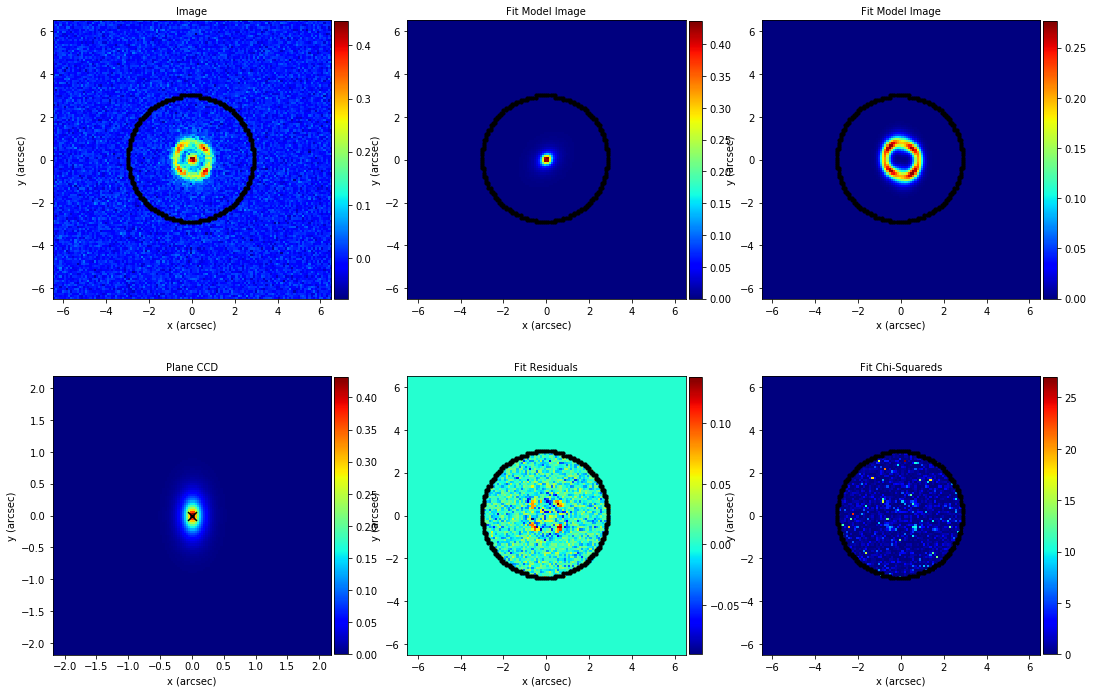

In [13]:
light_traces_mass_phase = LightTracesMassPhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                       mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                               phase_name='4_light_traces_mass')
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failure'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
light_traces_mass_phase_result = light_traces_mass_phase.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')
lens_fit_plotters.plot_fit_subplot(fit=light_traces_mass_phase_result.most_likely_fit)

The results look pretty good. Our source galaxy fits the data pretty well, and we've clearly inferred a model that looks similar to the one above. However, inspection of the residuals shows that the fit wasn't quite as good as the custom-phase above.

It turns out that when I simulated this image, light didn't perfectly trace mass. The light-profile's axis-ratio was 0.9, whereas the mass-profiles was 0.8. The quality of the fit has suffered as a result, and the likelihood we've inferred is lower.

Herein lies the pitfalls of making assumptions in science - they may make your model less realistic and your results worse! Nevertheless, our lens model is clearly much better than it was in the previous tutorial, so making assumptions isn't a bad idea if you're struggling to fit the data t all.

Again, lets consider the advantages and disadvantages of this approach:

- Advantage - By reducing parameter space's complexity, we inferred the global maximum likelihood.

- Advantage - The phase is not specific to one lens - we could run it on many strong lens images.

- Disadvantage - Our model was less realistic, and our fit suffered as a result.

__Approach 3 -  Look Harder__

In approaches 1 and 2, we extended our non-linear search an olive branch and generously helped it find the highest likelihood regions of parameter space. In approach 3 ,we're going to be stern with our non-linear search, and tell it 'look harder'.

Basically, every non-linear search algorithm has a set of parameters that govern how thoroughly it searches parameter space. The more thoroughly it looks, the more likely it is that it'll find the global maximum lens model. However, the search will also take longer - and we don't want it to take too long to get some results.

Lets setup a phase, and overwrite some of the non-linear search's parameters from the defaults it assumes in the 'config/non_linear.ini' config file:

In [15]:
custom_non_linear_phase = ph.LensSourcePlanePhase(lens_galaxies=dict(lens=gm.GalaxyModel(light=lp.EllipticalSersic,
                                                                                mass=mp.EllipticalIsothermal)),
                                      source_galaxies=dict(source=gm.GalaxyModel(light=lp.EllipticalExponential)),
                                      optimizer_class=nl.MultiNest,
                                                  phase_name='4_custom_non_linear')

The 'optimizer' below is MultiNest, the non-linear search we're using.

When MultiNest searches non-linear parameter space, it places down a set of 'live-points', each of which corresponds to a particular lens model (set of parameters) and each has an associted likelihood. If it guesses a new lens model with a higher likelihood than any of the currently active live points, this new lens model will become an active point. As a result, the active point with the lowest likelihood is discarded.

The more live points MultiNest uses, the more thoroughly it will sample parameter space. Lets increase the number of points from the default value (50) to 100.

In [16]:
custom_non_linear_phase.optimizer.n_live_points = 100

When MultiNest thinks its found a 'peak' likelihood in parameter space, it begins to converge around this peak. It does this by guessing lens models with similar parameters. However, this peak might not be the global maximum, and if MultiNest converges too quickly around a peak it won't realise this before its too late.

The sampling efficiency therefore describes how quickly MultiNest converges around a peak. It assumes values between 0.0 and 1.0, where 1.0 corresponds to the fastest convergance but highest risk of not locating the global maximum. Lets reduce the sampling efficiency from 0.8 to 0.5.

In [18]:
custom_non_linear_phase.optimizer.sampling_efficiency = 0.5

These are the two most important MultiNest parameters controlling how it navigates parameter space, so lets run this phase and see if our more detailed inspection of parameter space finds the correct lens model.

In [19]:
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failure'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
custom_non_linear_result = custom_non_linear_phase.run(data=ccd_data)
print('MultiNest has finished run - you may now continue the notebook.')

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/4_dealing_with_failurefolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/4_custom_non_linear/optimizer/multinest.txt
Removed no burn in


MultiNest has finished run - you may now continue the notebook.


Indeed, it does. Thus, we can always brute-force our way to a good lens model, if all else fails.

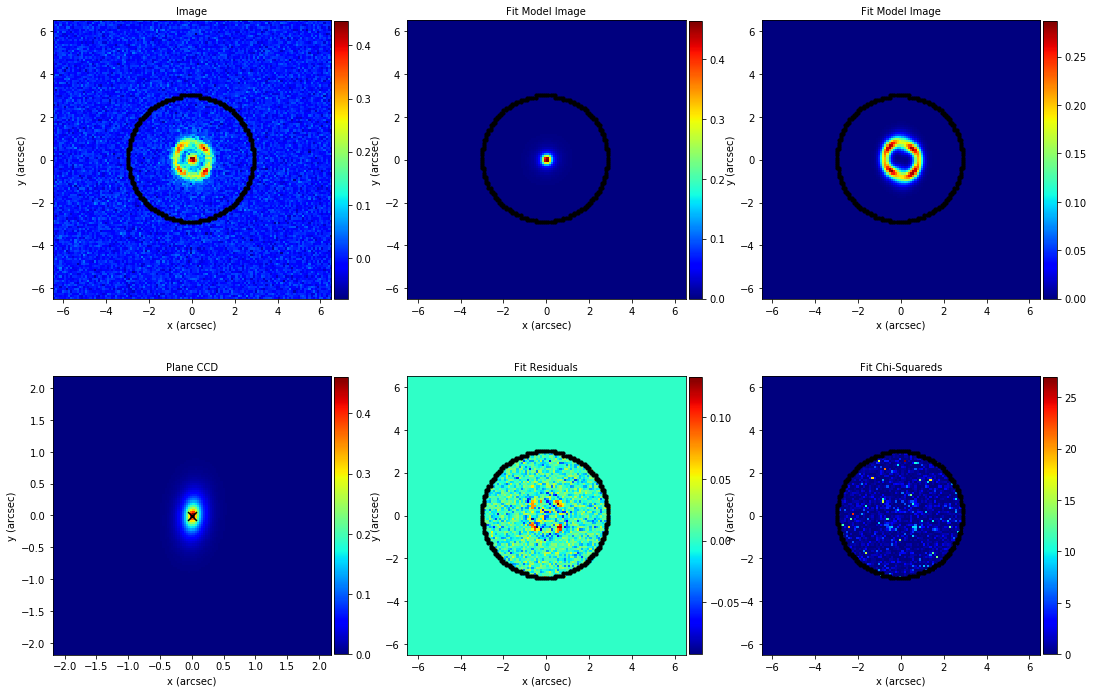

In [20]:
lens_fit_plotters.plot_fit_subplot(fit=custom_non_linear_result.most_likely_fit)


Finally, lets list the advantages and disadvantages of this approach:

- Advantage - Its easy to setup, we just increase n_live_points or decrease sampling_efficiency.

- Advantage - It generalizes to any strong lens.

- Advantage - We didn't have to make our model less realistic.

- Disadvantage - Its expensive. Very expensive. The run-time of this phase was over 6 hours. For more complex models we could be talking days or weeks (or, dare I say it, months).

So, there we have it, we can now fit strong lenses with PyAutoLens. And if it fails, we know how to get it to work. I hope you're feeling pretty smug. You might even be thinking 'why should I bother with the rest of these tutorials, if I can fit strong a lens already'.

Well, my friend, I want you to think about the last disadvantage listed above. If modeling a single lens could really take as long as a month, are you really willing to spend your valuable time waiting for this? I'm not, which is why I developed PyAutoLens, and in the next tutorial we'll see how we can get the best of both worlds - realistic, complex lens model that take mere hours to infer!

Before doing that though, I want you to go over the advantages and disadvantages listed above again, and think whether we could combine these different approaches to get the best of all worlds.